## Embedding training and finetuning
#### Jianfeng Ke
#### Email: jianfeng_ke@student.uml.edu

In [32]:
# import pytorch libraries
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

import os
import csv
import copy
import math
import time
import random
import pickle
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import mse
from scipy import stats
from scipy.stats import spearmanr
from scipy.spatial.distance import cosine
from scipy.special import expit as sigmoid
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score, average_precision_score

# use gpu if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
# this is the path where you download and unzip the drkg.tar.gz
ct_dir = '/project/pi_rachel_melamed_uml_edu/Panos/drug_combo_jianfeng/CT_20250605/'
# this is the path where you save your preprocessing data from clinical trials
drkg_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Drug_combinations/06122025/drkg_embedding_preprocessing/'
# this is your current working directory where you want to save the embeddings after training and finetuning
work_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Drug_combinations/06122025/embedding_training_and_finetuning/'

# Load the clinical trials table of 1 drug and 1 condition
drug_cond_df = pd.read_csv(ct_dir + 'drug_condition_20250605.txt', delimiter='\t')

# Load the DRKG embeddings
embedding_drug=pd.read_csv(drkg_dir + 'drkg_filtered_drug_embedding.csv')
embedding_drug=embedding_drug.set_index('id')
embedding_drug1=embedding_drug.reindex(drug_cond_df['drug'].unique())
embedding_drug1=embedding_drug1.dropna()
embedding_cond=pd.read_csv(drkg_dir + 'drkg_filtered_condition_embedding.csv')
embedding_cond=embedding_cond.set_index('id')
embedding_cond1=embedding_cond.reindex(drug_cond_df['condition'].unique())
embedding_cond1=embedding_cond1.dropna()

# count the number of nodes of each kind
n_emb = len(embedding_cond1) + len(embedding_drug1)
n_drug = len(set(drug_cond_df['drug']))
n_drug_w_emb = embedding_drug1.shape[0]
n_cond = len(set(drug_cond_df['condition']))
n_cond_w_emb = embedding_cond1.shape[0]
N_node = n_cond + n_drug

input_emb_size = 400
# merge the drug embeddings and condition embeddings
merged_emb = pd.concat([embedding_drug1, embedding_cond1], ignore_index=False)

# reindex the existing DRKG embeddings
emb_id_mapping = {emb_id: i for i, emb_id in enumerate(merged_emb.index)}
# find all the drugs and conditions without DRKG embeddings
for i in range(drug_cond_df.shape[0]):
    drug_name = drug_cond_df['drug'][i]
    if drug_name not in emb_id_mapping.keys():
        emb_id_mapping[drug_name] = max(emb_id_mapping.values())+1
for i in range(drug_cond_df.shape[0]):
    cond_name = drug_cond_df['condition'][i]
    if cond_name not in emb_id_mapping.keys():
        emb_id_mapping[cond_name] = max(emb_id_mapping.values())+1
# final order of embeddings by index:
# drkg_drug -> drkg_cond -> non_drkg_drug -> non_drkg_cond
        
# map the drug or cond ids into indices for drug_cond_df
import warnings
warnings.filterwarnings("ignore")
drug_cond_df['drug_idx'] = drug_cond_df['drug'].map(emb_id_mapping)
drug_cond_df['cond_idx'] = drug_cond_df['condition'].map(emb_id_mapping)

In [34]:
class Embedding_training(torch.nn.Module):
    def __init__(self, input_emb_size, N_node, n_emb):
        super().__init__()
        # embedding layer 1 is for the trained DRKG embeddings
        self.emb1 = torch.nn.Embedding(n_emb, input_emb_size)
        # embedding layer 2 is for the nodes without DRKG embeddings
        self.emb2 = torch.nn.Embedding(N_node-n_emb, input_emb_size)

    def forward(self, drug_list, cond_list):
        # embedding 1 is for drkg embedding
        embed_layer1 = self.emb1(torch.tensor(range(n_emb), dtype=torch.long))
        # embedding 2 is for the nodes without drkg embeddings
        embed_layer2 = self.emb2(torch.tensor(range(N_node-n_emb), dtype=torch.long))
        embeddings = torch.cat([embed_layer1, embed_layer2], dim=0)
        z = embeddings
        drug_tensor_mat = z[drug_list]
        cond_tensor_mat = z[cond_list]
        dot_product = (cond_tensor_mat * drug_tensor_mat).sum(dim=1)
        pred = torch.sigmoid(dot_product)
        
        return pred
    

class Embedding_finetuning(torch.nn.Module):
    def __init__(self, input_emb_size, N_node):
        super().__init__()
        # read the pretrained embeddings
        self.emb = torch.nn.Embedding(N_node, input_emb_size)
        
    def forward(self, drug_list, cond_list):
        z = self.emb(torch.tensor(range(N_node), dtype=torch.long))
        drug_tensor_mat = z[drug_list]
        cond_tensor_mat = z[cond_list]
        dot_product = (drug_tensor_mat * cond_tensor_mat).sum(dim=1)
        pred = torch.sigmoid(dot_product)
        
        return pred

    
# for the output, each batch should be two lists: cond_list and drug_list
def build_batch(batch_size, pairs):
    if batch_size==len(pairs):
        drug_node = np.array(pairs).T[0].tolist()
        cond_node = np.array(pairs).T[1].tolist()
        output_list = [[drug_node, cond_node]]
        return output_list
    else:
        shuffled_pairs = random.sample(pairs, len(pairs))
        # Create batches by slicing the shuffled list
        shuffled_pairs_in_batch = [shuffled_pairs[i:i + batch_size] for i in range(0, len(shuffled_pairs)-batch_size, batch_size)]
        output_list = []
        for l in shuffled_pairs_in_batch:
            drug_node = np.array(l).T[0].tolist()
            cond_node = np.array(l).T[1].tolist()
            output_list.append([drug_node, cond_node])
        return output_list


# do negative_sampling every batch
def negative_sampling_by_edge(batch_size, n_drug, n_cond, all_pairs, pos_pairs):
    count = 0
    neg_pairs = random.sample(all_pairs, batch_size+len(pos_pairs))
    random.shuffle(neg_pairs)
    pos_pairs_set = {tuple(l) for l in pos_pairs}
    neg_pairs_set = {tuple(l) for l in neg_pairs}
    # Find the pairs in neg_pairs_set that are not in pos_pairs_set
    pick_neg_pairs = [list(l) for l in (neg_pairs_set - pos_pairs_set)][:batch_size]
    neg_drug_list = np.array(pick_neg_pairs).T[0].tolist()
    neg_cond_list = np.array(pick_neg_pairs).T[1].tolist()
    
    return neg_drug_list, neg_cond_list

    
def train1(drug_list, cond_list, real):
    optimizer.zero_grad()
    pred = model.forward(drug_list, cond_list)
    loss = criterion(pred, real)
    loss.backward()
    # clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_value)
    model.emb1.weight.data = torch.clamp(model.emb1.weight.data, min=min_clip_value, max=max_clip_value)
    model.emb2.weight.data = torch.clamp(model.emb2.weight.data, min=min_clip_value, max=max_clip_value)
    optimizer.step()

    return loss


def test(pos_pairs, test_pairs):
    # randomly pick the same number of real negative edge for testing
    neg_drug_list, neg_cond_list = negative_sampling_by_edge(len(test_pairs), n_drug, n_cond, all_pairs, pos_pairs+test_pairs)
    pos_drug_list = [x[0] for x in test_pairs]
    pos_cond_list = [x[1] for x in test_pairs]
    model.eval()
    pred = model(pos_drug_list+neg_drug_list, pos_cond_list+neg_cond_list)
    real = torch.tensor([1] * len(test_pairs) + [0] * len(test_pairs)).float()
    loss = criterion(pred, real)
    prediction = pred.detach().numpy()
    # compute the auc score
    roc_auc = roc_auc_score(real, prediction)
    pr_auc = average_precision_score(real, prediction)
    return loss, roc_auc, pr_auc


def medium_of_drug_cond_emb_for_embedding_training(input_model):
    # Extract and concatenate embeddings once
    emb1_layer = np.array(input_model.emb1.weight.data)
    emb2_layer = np.array(input_model.emb2.weight.data)
    emb_layer = np.concatenate((emb1_layer, emb2_layer))
    # Index extraction for conditions and drugs
    cond_indices = drug_cond_df['cond_idx'].values
    drug_indices = drug_cond_df['drug_idx'].values
    # Retrieve the corresponding embeddings
    cond_embs = emb_layer[cond_indices]
    drug_embs = emb_layer[drug_indices]
    # Compute dot product and apply sigmoid
    dot_products = sigmoid(np.einsum('ij,ij->i', cond_embs, drug_embs))
    # Split dot products based on condition
    n_emb = len(embedding_cond1) + len(embedding_drug1)
    is_drkg_pair = (cond_indices < n_emb) & (drug_indices < n_emb)
    # Compute medians
    medium_drkg = np.median(dot_products[is_drkg_pair])
    medium_trained = np.median(dot_products[~is_drkg_pair])
    
    return medium_drkg, medium_trained


# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### Embedding training

In [35]:
### Build training set
train_partition = 1
total_edges = drug_cond_df.shape[0]
rows = list(range(total_edges))
train_size = int(total_edges * train_partition)
# Randomly shuffle the rows
random.shuffle(rows)
# Split the shuffled rows into training and testing groups
training_row = rows[:train_size]
testing_row = rows[train_size:] 
training_pos_edge = drug_cond_df.iloc[training_row, ].reset_index(drop=True)
testing_pos_edge = drug_cond_df.iloc[testing_row, ].reset_index(drop=True)
# positive pairs and testing pairs
pos_pairs = [[training_pos_edge['drug_idx'][i], training_pos_edge['cond_idx'][i]] for i in range(len(training_pos_edge))]
test_pairs = [[testing_pos_edge['drug_idx'][i], testing_pos_edge['cond_idx'][i]] for i in range(len(testing_pos_edge))]

# all pairs between drugs and conditions
unique_drug_idx_list = sorted(list(set(drug_cond_df['drug_idx'].tolist())))
unique_cond_idx_list = sorted(list(set(drug_cond_df['cond_idx'].tolist())))
all_pairs = [[i,j] for i in unique_drug_idx_list for j in unique_cond_idx_list]

In [36]:
# settings
input_emb_size = 400
batch_size = 8192
# batch_size = len(drug_cond_df)
lr = 0.001
epoch = 10000
min_clip_value = merged_emb.min().min()
max_clip_value = merged_emb.max().max()
gradient_clip_value = 1.0


model = Embedding_training(input_emb_size, N_node, n_emb)
torch.nn.init.normal_(model.emb1.weight, mean=0, std=0.5)
torch.nn.init.normal_(model.emb2.weight, mean=0, std=0.5)

# load pretrained drkg embeddings
pretrained_embedding = torch.nn.Embedding(n_emb, input_emb_size)
merged_emb = pd.concat([embedding_drug1, embedding_cond1], ignore_index=False)
drkg_emb = torch.tensor(merged_emb.values, dtype=torch.float32)
pretrained_embedding.weight = torch.nn.Parameter(drkg_emb)
model.emb1.weight.data = pretrained_embedding.weight.data

# freeze drkg pretrained embeddings and enable our initial embeddings to train
model.emb1.weight.requires_grad = False
model.emb2.weight.requires_grad = True

optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
criterion = torch.nn.BCELoss()

# lists of error
train_loss_list, test_loss_list = [], []
roc_auc_list, pr_auc_list = [], []
medium_drkg_list, medium_trained_list = [], []

# positive pairs and testing positive pairs
pos_pairs = pos_pairs
test_pairs = test_pairs

# Initial error
#test_loss, roc_auc, pr_auc = test(pos_pairs, test_pairs)
medium_drkg, medium_trained = medium_of_drug_cond_emb_for_embedding_training(model)
print(#f'Initial Error, Test Loss:{test_loss:.4f}, ' + 
      #f'roc_auc:{roc_auc:.4f}, pr_auc:{pr_auc:.4f}, ' + 
      f'medium_drkg:{medium_drkg:.4f}, medium_trained:{medium_trained:.4f}\n')

for e in range(epoch):
    # build batchs of training
    batch_list = build_batch(batch_size, pos_pairs)
    # model training
    total_loss_in_batch = 0
    for batch in batch_list:
        pos_drug_list = batch[0]
        pos_cond_list = batch[1]
        neg_drug_list, neg_cond_list = negative_sampling_by_edge(batch_size, n_drug, n_cond, all_pairs, pos_pairs)
        real = torch.tensor([1] * batch_size + [0] * batch_size).float()
        drug_list = pos_drug_list + neg_drug_list
        cond_list = pos_cond_list + neg_cond_list
        batch_loss = train1(drug_list, cond_list, real)
        total_loss_in_batch = total_loss_in_batch + batch_loss
    train_loss_avg = total_loss_in_batch / len(batch_list)
    train_loss_list.append(train_loss_avg.detach().numpy())
    # model testing
    #test_loss, roc_auc, pr_auc = test(pos_pairs, test_pairs)
    #test_loss_list.append(test_loss.detach().numpy())
    #roc_auc_list.append(roc_auc)
    #pr_auc_list.append(pr_auc)
    # compute the medium of the dot products of embeddings of drug-cond pairs
    medium_drkg, medium_trained = medium_of_drug_cond_emb_for_embedding_training(model)
    medium_drkg_list.append(medium_drkg)
    medium_trained_list.append(medium_trained)

    print(f'Epoch:{(e+1):03d} ,' + 
          f'Train Loss:{train_loss_avg:.4f}, ' + 
          # f'Test Loss:{test_loss:.4f}, ' + 
          # f'roc_auc:{roc_auc:.4f}, pr_auc:{pr_auc:.4f}, ' + 
          f'medium_drkg:{medium_drkg:.4f}, medium_trained:{medium_trained:.4f}')
    
    # stop training when the embeddings are well-trained
    if medium_trained > medium_drkg:
        break
        

medium_drkg:0.9374, medium_trained:0.5011

Epoch:001 ,Train Loss:2.9730, medium_drkg:0.9374, medium_trained:0.5815
Epoch:002 ,Train Loss:3.0078, medium_drkg:0.9374, medium_trained:0.6458
Epoch:003 ,Train Loss:2.9677, medium_drkg:0.9374, medium_trained:0.6973
Epoch:004 ,Train Loss:2.9046, medium_drkg:0.9374, medium_trained:0.7431
Epoch:005 ,Train Loss:2.8561, medium_drkg:0.9374, medium_trained:0.7779
Epoch:006 ,Train Loss:2.8725, medium_drkg:0.9374, medium_trained:0.8009
Epoch:007 ,Train Loss:2.8733, medium_drkg:0.9374, medium_trained:0.8199
Epoch:008 ,Train Loss:2.8606, medium_drkg:0.9374, medium_trained:0.8328
Epoch:009 ,Train Loss:2.8335, medium_drkg:0.9374, medium_trained:0.8427
Epoch:010 ,Train Loss:2.8173, medium_drkg:0.9374, medium_trained:0.8470
Epoch:011 ,Train Loss:2.8199, medium_drkg:0.9374, medium_trained:0.8514
Epoch:012 ,Train Loss:2.8369, medium_drkg:0.9374, medium_trained:0.8530
Epoch:013 ,Train Loss:2.8156, medium_drkg:0.9374, medium_trained:0.8552
Epoch:014 ,Train Loss

In [37]:
# # save the trained embeddings
# trained_emb = model.emb2
# trained_emb_weights = trained_emb.weight.data.numpy()
# embedding_save_path = work_dir+'trained_emb.npy'
# np.save(embedding_save_path, trained_emb_weights)

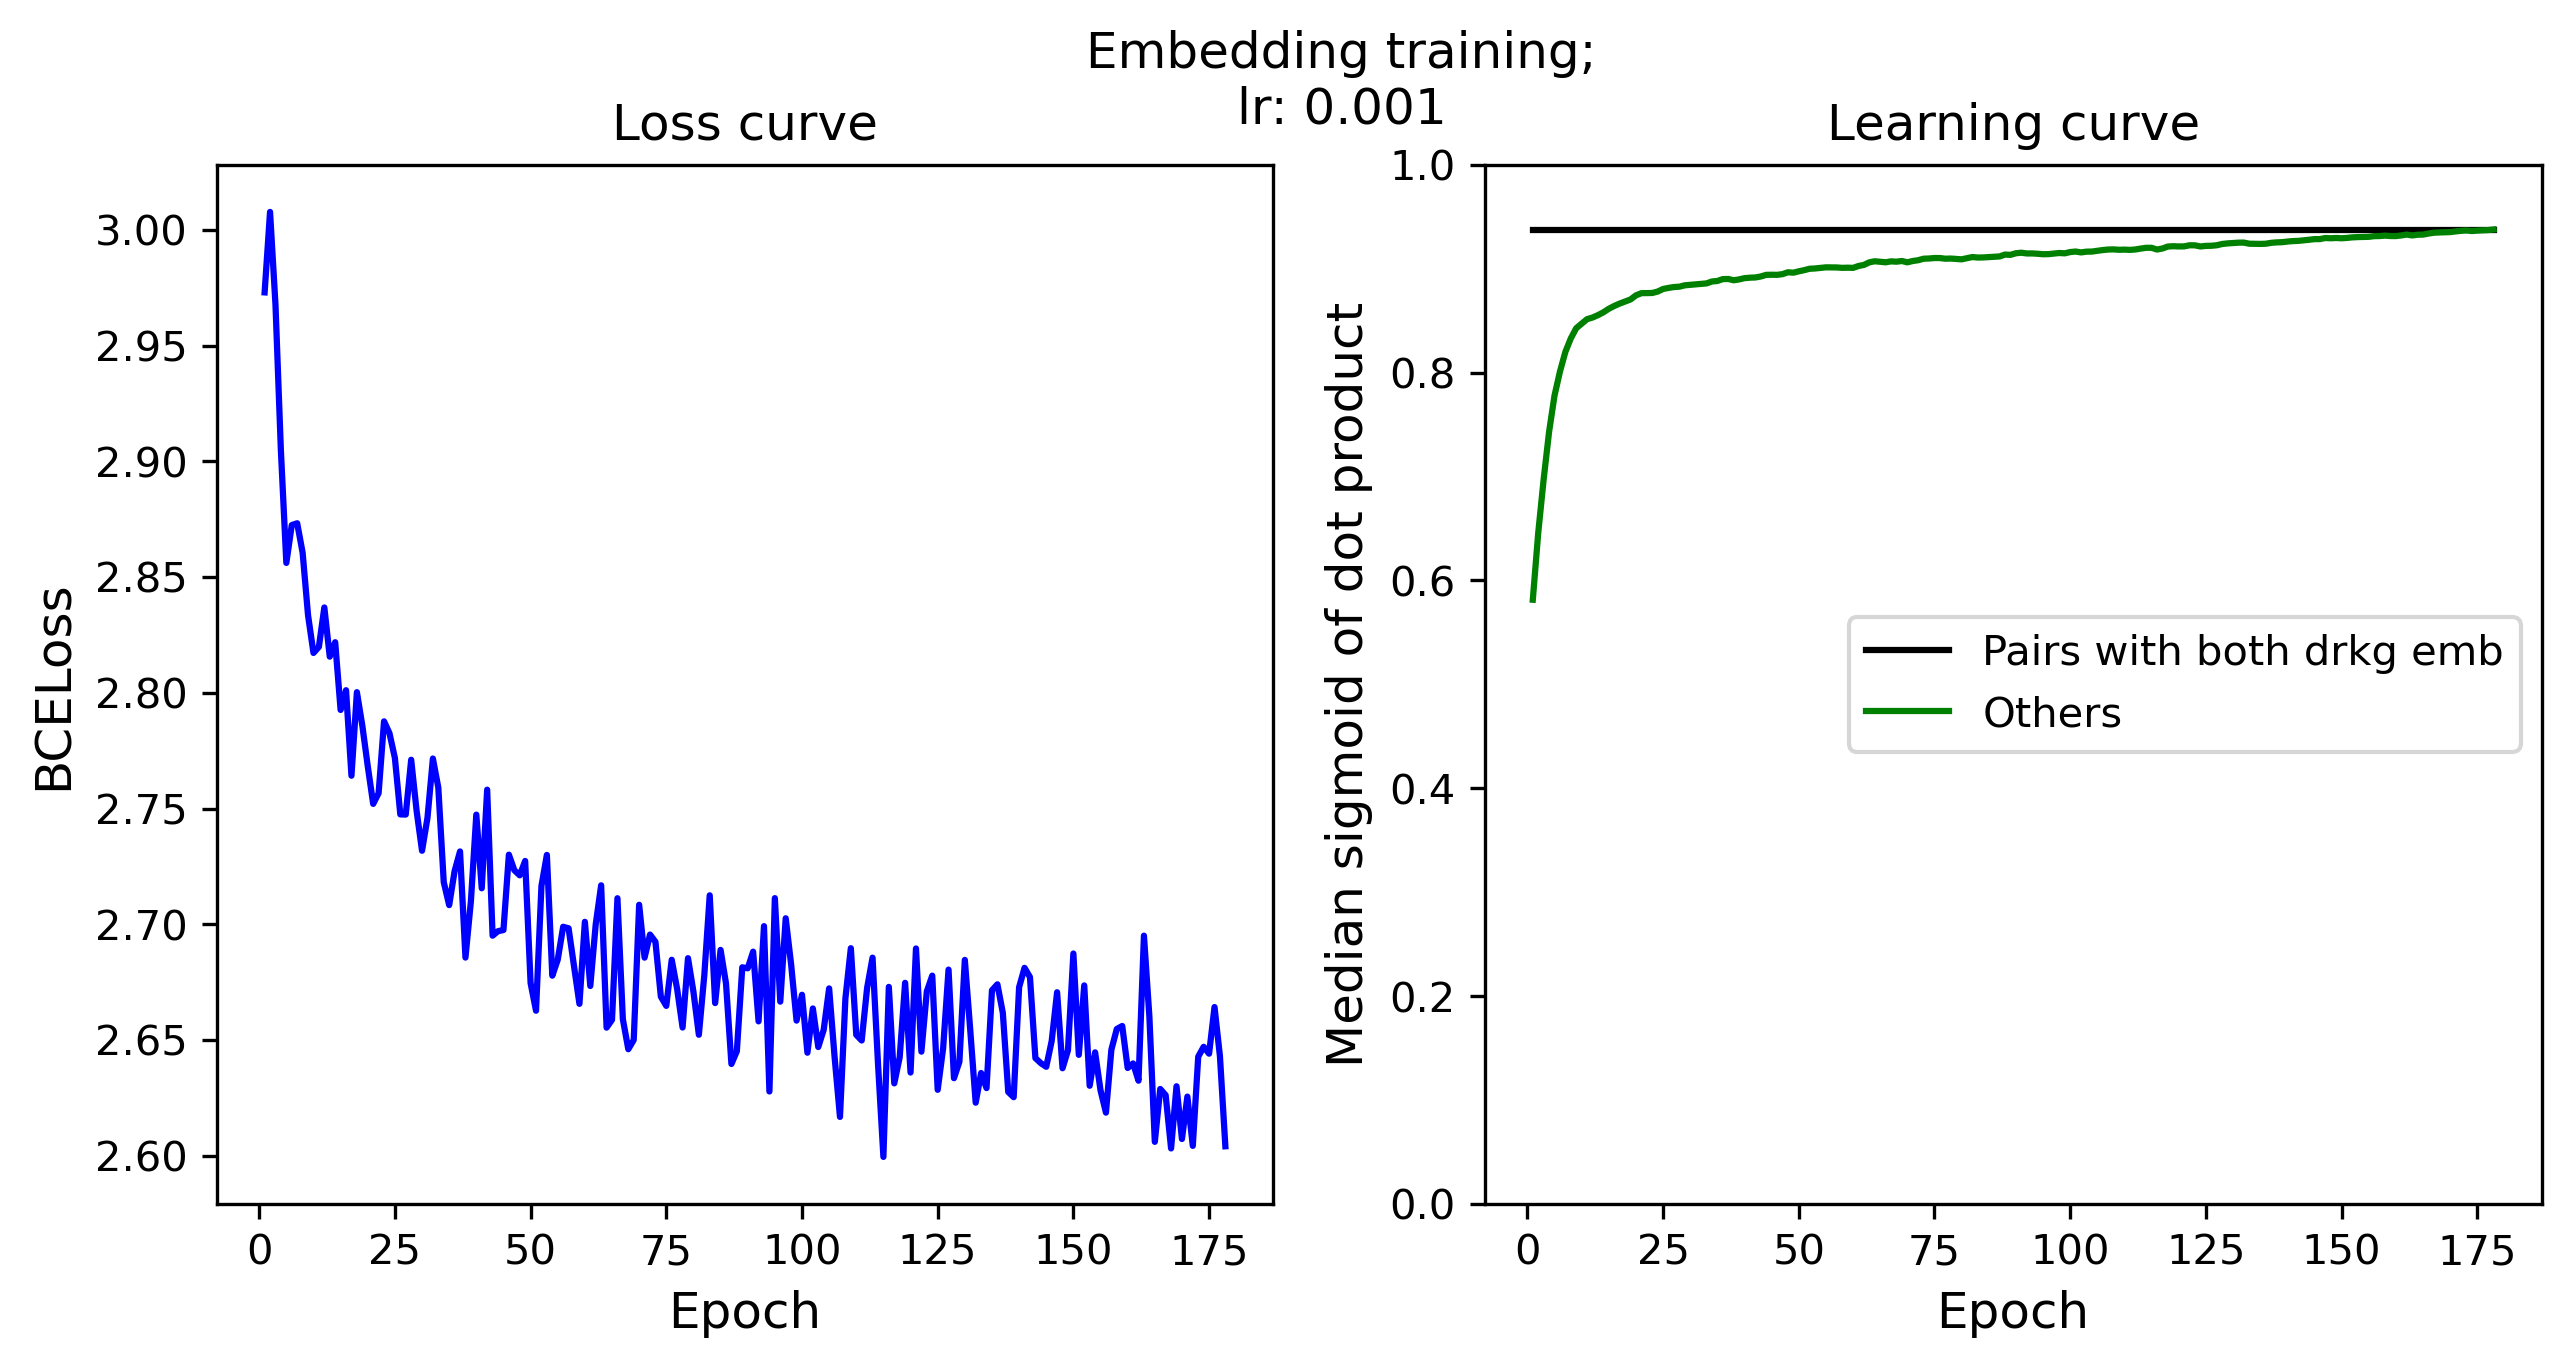

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), dpi=300)
fig.suptitle(f"Embedding training;\n" + 
             f"lr: {lr}", fontsize=12)

axes[0].plot(range(1,1+len(train_loss_list)), train_loss_list, color='blue')
axes[0].set_title('Loss curve', fontsize=12)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('BCELoss', fontsize=12)
# axes[0].legend(loc='upper right')

axes[1].plot(range(1,1+len(medium_drkg_list)), medium_drkg_list, color='black', label="Pairs with both drkg emb")
axes[1].plot(range(1,1+len(medium_trained_list)), medium_trained_list, color='green', label="Others")
axes[1].set_title('Learning curve', fontsize=12)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Median sigmoid of dot product', fontsize=12)
axes[1].set_ylim(0, 1)
axes[1].legend(loc='right')

plt.show()

### Load the trained embedding before finetuning and visualize the dot product

In [23]:
model = Embedding_training(input_emb_size, N_node, n_emb)

# load pretrained drkg embeddings
drkg_embedding = torch.nn.Embedding(n_emb, input_emb_size)
merged_emb = pd.concat([embedding_drug1, embedding_cond1], ignore_index=False)
drkg_emb = torch.tensor(merged_emb.values, dtype=torch.float32)
model.emb1.weight = torch.nn.Parameter(drkg_emb)
# load the trained embeddings
embedding_save_path = work_dir+'trained_emb.npy'
trained_emb_weights = np.load(embedding_save_path)
model.emb2.weight.data.copy_(torch.from_numpy(trained_emb_weights))

tensor([[ 0.0631,  0.8399,  1.4078,  ...,  0.5598,  0.4093,  0.1142],
        [ 0.3201,  0.2700, -0.4195,  ..., -0.3699, -0.2461, -0.1527],
        [-0.2552,  0.2503,  0.4942,  ...,  0.6048,  0.4848,  0.1151],
        ...,
        [-0.2747,  0.0240, -0.2111,  ..., -0.1152, -0.6184,  0.0833],
        [-0.0701, -0.2297, -0.4603,  ...,  0.6137, -1.0569, -0.2525],
        [-0.0061,  0.9897,  0.0869,  ...,  1.0587,  1.0009,  0.1590]])

In [24]:
# Extract and concatenate embeddings once
emb1_layer = np.array(model.emb1.weight.data)
emb2_layer = np.array(model.emb2.weight.data)
emb_layer = np.concatenate((emb1_layer, emb2_layer))
# Index extraction for conditions and drugs
cond_indices = drug_cond_df['cond_idx'].values
drug_indices = drug_cond_df['drug_idx'].values
# Retrieve the corresponding embeddings
cond_embs = emb_layer[cond_indices]
drug_embs = emb_layer[drug_indices]
# Compute dot product and apply sigmoid
dot_products = sigmoid(np.einsum('ij,ij->i', cond_embs, drug_embs))
# Split dot products based on condition
n_emb = len(embedding_cond1) + len(embedding_drug1)
is_drkg_pair = (cond_indices < n_emb) & (drug_indices < n_emb)
# Compute medians
dot_product_list_drkg = dot_products[is_drkg_pair]
dot_product_list_trained = dot_products[~is_drkg_pair]

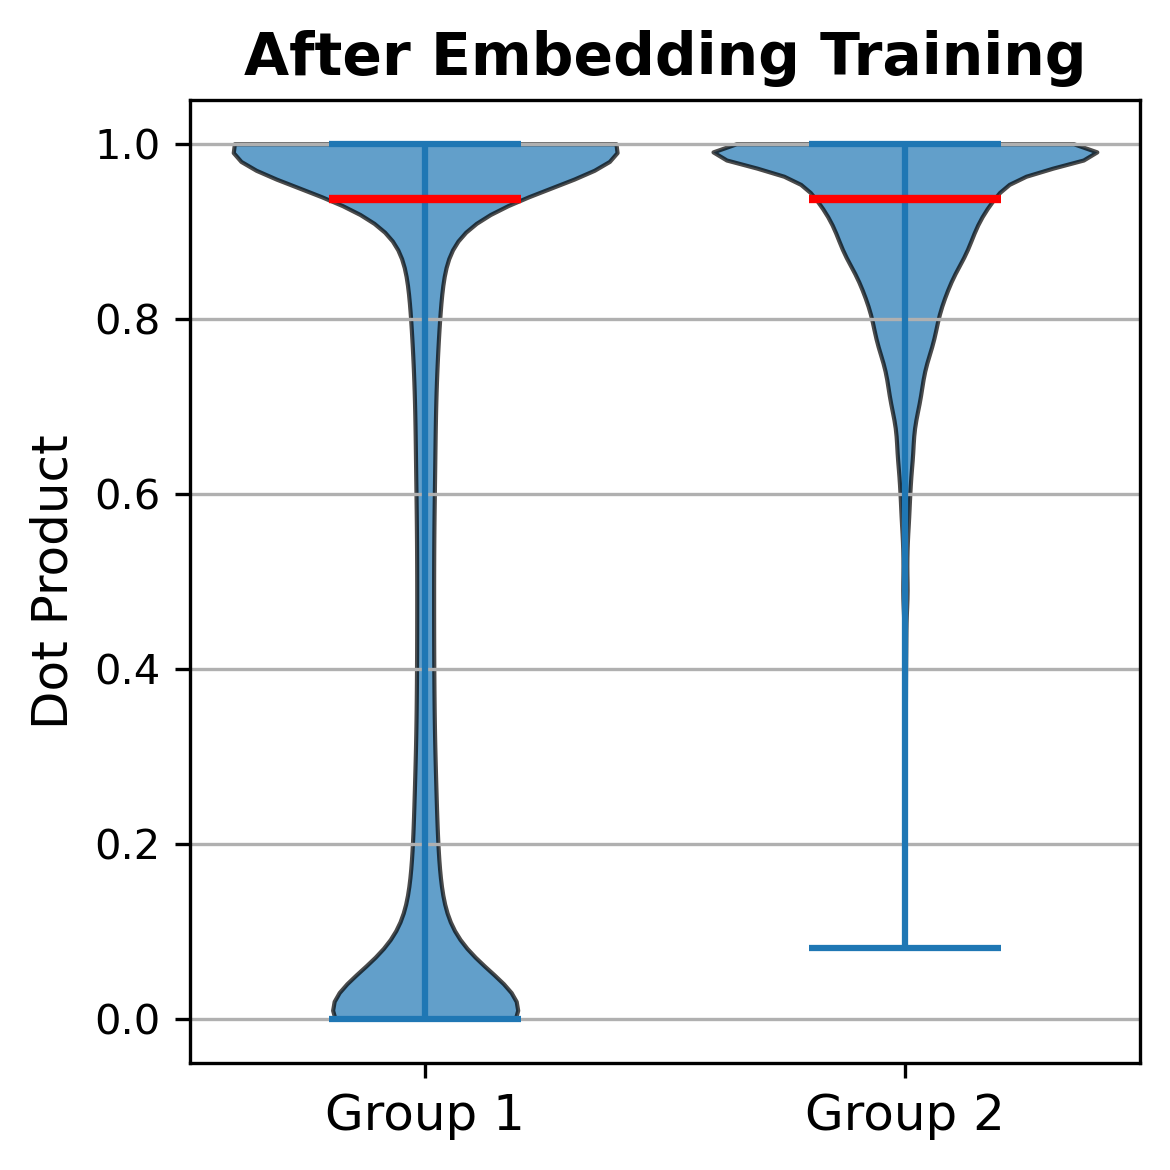

In [25]:
# plot
data = [dot_product_list_drkg, dot_product_list_trained]
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

# violin plot with polished appearance
parts = ax.violinplot(data, showmedians=True, widths=0.8)

# make violins cleaner (optional: slightly transparent)
for pc in parts['bodies']:
    pc.set_facecolor('#1f77b4')  # or any color you like
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# set median line color and width
if 'cmedians' in parts:
    parts['cmedians'].set_color('red')
    parts['cmedians'].set_linewidth(2)

# axes and labels
ax.set_xticks([1, 2])
ax.set_xticklabels(['Group 1', 'Group 2'], fontsize=12)
ax.tick_params(axis='y', labelsize=10)
ax.set_ylabel('Dot Product', fontsize=12)
ax.set_title('After Embedding Training', fontsize=14, weight='bold')

# add grid for better readability
ax.yaxis.grid(True)

ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

### Embedding finetuning

In [26]:
### Build training set and testing set
train_partition = 1
total_edges = drug_cond_df.shape[0]
rows = list(range(total_edges))
train_size = int(total_edges * train_partition)
# Randomly shuffle the rows
random.shuffle(rows)
# Split the shuffled rows into training and testing groups
training_row = rows[:train_size]
testing_row = rows[train_size:] 
training_pos_edge = drug_cond_df.iloc[training_row, ].reset_index(drop=True)
testing_pos_edge = drug_cond_df.iloc[testing_row, ].reset_index(drop=True)
# positive pairs and testing pairs
pos_pairs = [[training_pos_edge['drug_idx'][i], training_pos_edge['cond_idx'][i]] for i in range(len(training_pos_edge))]
test_pairs = [[testing_pos_edge['drug_idx'][i], testing_pos_edge['cond_idx'][i]] for i in range(len(testing_pos_edge))]

# all pairs between drugs and conditions
unique_drug_idx_list = sorted(list(set(drug_cond_df['drug_idx'].tolist())))
unique_cond_idx_list = sorted(list(set(drug_cond_df['cond_idx'].tolist())))
all_pairs = [[i,j] for i in unique_drug_idx_list for j in unique_cond_idx_list]


def medium_of_drug_cond_emb_for_embedding_finetuning(input_model):
    # Extract the embeddings
    emb_layer = np.array(input_model.emb.weight.data)
    # Index extraction for conditions and drugs
    cond_indices = drug_cond_df['cond_idx'].values
    drug_indices = drug_cond_df['drug_idx'].values
    # Retrieve the corresponding embeddings
    cond_embs = emb_layer[cond_indices]
    drug_embs = emb_layer[drug_indices]
    # Compute dot product and apply sigmoid
    dot_products = sigmoid(np.einsum('ij,ij->i', cond_embs, drug_embs))
    # Split dot products based on condition
    n_emb = len(embedding_cond1) + len(embedding_drug1)
    is_drkg_pair = (cond_indices < n_emb) & (drug_indices < n_emb)
    # Compute medians
    medium_drkg = np.median(dot_products[is_drkg_pair])
    medium_trained = np.median(dot_products[~is_drkg_pair])
    
    return medium_drkg, medium_trained


def train2(drug_list, cond_list, real):
    optimizer.zero_grad()
    pred = model.forward(drug_list, cond_list)
    loss = criterion(pred, real)
    loss.backward()
    # clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_value)
    model.emb.weight.data = torch.clamp(model.emb.weight.data, min=min_clip_value, max=max_clip_value)
    optimizer.step()

    return loss

In [27]:
# settings
input_emb_size = 400
batch_size = 8192
# batch_size = len(drug_cond_df)
lr = 0.0001
epoch = 2000
min_clip_value = merged_emb.min().min()
max_clip_value = merged_emb.max().max()
gradient_clip_value = 1.0


model = Embedding_finetuning(input_emb_size, N_node)

# load pretrained drkg embeddings
drkg_embedding = torch.nn.Embedding(n_emb, input_emb_size)
merged_emb = pd.concat([embedding_drug1, embedding_cond1], ignore_index=False)
drkg_emb = torch.tensor(merged_emb.values, dtype=torch.float32)
drkg_embedding.weight = torch.nn.Parameter(drkg_emb)
# load the trained embeddings
embedding_save_path = work_dir+'trained_emb.npy'
trained_emb_weights = np.load(embedding_save_path)
trained_embedding = torch.nn.Embedding(N_node-n_emb, input_emb_size)
trained_embedding.weight.data.copy_(torch.from_numpy(trained_emb_weights))
# concat two embeddings layers together
embeddings = torch.cat((drkg_embedding.weight, trained_embedding.weight), dim=0)

# set the embedding weights to pretrained gene embeddings
pretrained_embedding = torch.nn.Embedding(N_node, input_emb_size)
pretrained_embedding.weight = torch.nn.Parameter(embeddings)
model.emb.weight.data = pretrained_embedding.weight.data
model.emb.requires_grad = True

optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
criterion = torch.nn.BCELoss()

# lists of error
train_loss_list, test_loss_list = [], []
roc_auc_list, pr_auc_list = [], []
medium_drkg_list, medium_trained_list = [], []

# positive pairs and testing positive pairs
pos_pairs = pos_pairs
test_pairs = test_pairs

# Initial error
# test_loss, roc_auc, pr_auc = test(pos_pairs, test_pairs)
medium_drkg, medium_trained = medium_of_drug_cond_emb_for_embedding_finetuning(model)
print(# f'Initial Error, Test Loss:{test_loss:.4f}, ' + 
      # f'roc_auc:{roc_auc:.4f}, pr_auc:{pr_auc:.4f}, ' + 
      f'medium_drkg:{medium_drkg:.4f}, medium_trained:{medium_trained:.4f}\n')

for e in range(epoch):
    # build batchs of training
    batch_list = build_batch(batch_size, pos_pairs)
    # model training
    total_loss_in_batch = 0
    for batch in batch_list:
        pos_drug_list = batch[0]
        pos_cond_list = batch[1]
        neg_drug_list, neg_cond_list = negative_sampling_by_edge(batch_size, n_drug, n_cond, all_pairs, pos_pairs)
        real = torch.tensor([1] * batch_size + [0] * batch_size).float()
        drug_list = pos_drug_list + neg_drug_list
        cond_list = pos_cond_list + neg_cond_list
        batch_loss = train2(drug_list, cond_list, real)
        total_loss_in_batch = total_loss_in_batch + batch_loss
    train_loss_avg = total_loss_in_batch / len(batch_list)
    train_loss_list.append(train_loss_avg.detach().numpy())
    # model testing
    # test_loss, roc_auc, pr_auc = test(pos_pairs, test_pairs)
    # test_loss_list.append(test_loss.detach().numpy())
    # roc_auc_list.append(roc_auc)
    # pr_auc_list.append(pr_auc)
    # compute the medium of the dot products of embeddings of drug-cond pairs
    medium_drkg, medium_trained = medium_of_drug_cond_emb_for_embedding_finetuning(model)
    medium_drkg_list.append(medium_drkg)
    medium_trained_list.append(medium_trained)

    print(f'Epoch:{(e+1):03d} ,' + 
          f'Train Loss:{train_loss_avg:.4f}, ' + 
          # f'Test Loss:{test_loss:.4f}, ' + 
          # f'roc_auc:{roc_auc:.4f}, pr_auc:{pr_auc:.4f}, ' + 
          f'medium_drkg:{medium_drkg:.4f}, medium_trained:{medium_trained:.4f}')
    
    # stop training when the embeddings are well-trained
    if medium_trained > medium_drkg:
        break
        

medium_drkg:0.9374, medium_trained:0.9374

Epoch:001 ,Train Loss:2.6297, medium_drkg:0.9420, medium_trained:0.9379
Epoch:002 ,Train Loss:2.6019, medium_drkg:0.9462, medium_trained:0.9381
Epoch:003 ,Train Loss:2.5277, medium_drkg:0.9498, medium_trained:0.9383
Epoch:004 ,Train Loss:2.4769, medium_drkg:0.9532, medium_trained:0.9384
Epoch:005 ,Train Loss:2.4572, medium_drkg:0.9564, medium_trained:0.9385
Epoch:006 ,Train Loss:2.4693, medium_drkg:0.9593, medium_trained:0.9386
Epoch:007 ,Train Loss:2.4063, medium_drkg:0.9619, medium_trained:0.9386
Epoch:008 ,Train Loss:2.3415, medium_drkg:0.9640, medium_trained:0.9386
Epoch:009 ,Train Loss:2.3259, medium_drkg:0.9663, medium_trained:0.9387
Epoch:010 ,Train Loss:2.2650, medium_drkg:0.9684, medium_trained:0.9388
Epoch:011 ,Train Loss:2.2474, medium_drkg:0.9703, medium_trained:0.9390
Epoch:012 ,Train Loss:2.2272, medium_drkg:0.9719, medium_trained:0.9390
Epoch:013 ,Train Loss:2.1984, medium_drkg:0.9735, medium_trained:0.9393
Epoch:014 ,Train Loss

In [28]:
# # save the finetuned embeddings
# finetuned_emb = model.emb
# finetuned_emb_weights = finetuned_emb.weight.data.numpy()
# embedding_save_path = work_dir+f'finetuned_emb_{train_partition}.npy'
# np.save(embedding_save_path, finetuned_emb_weights)

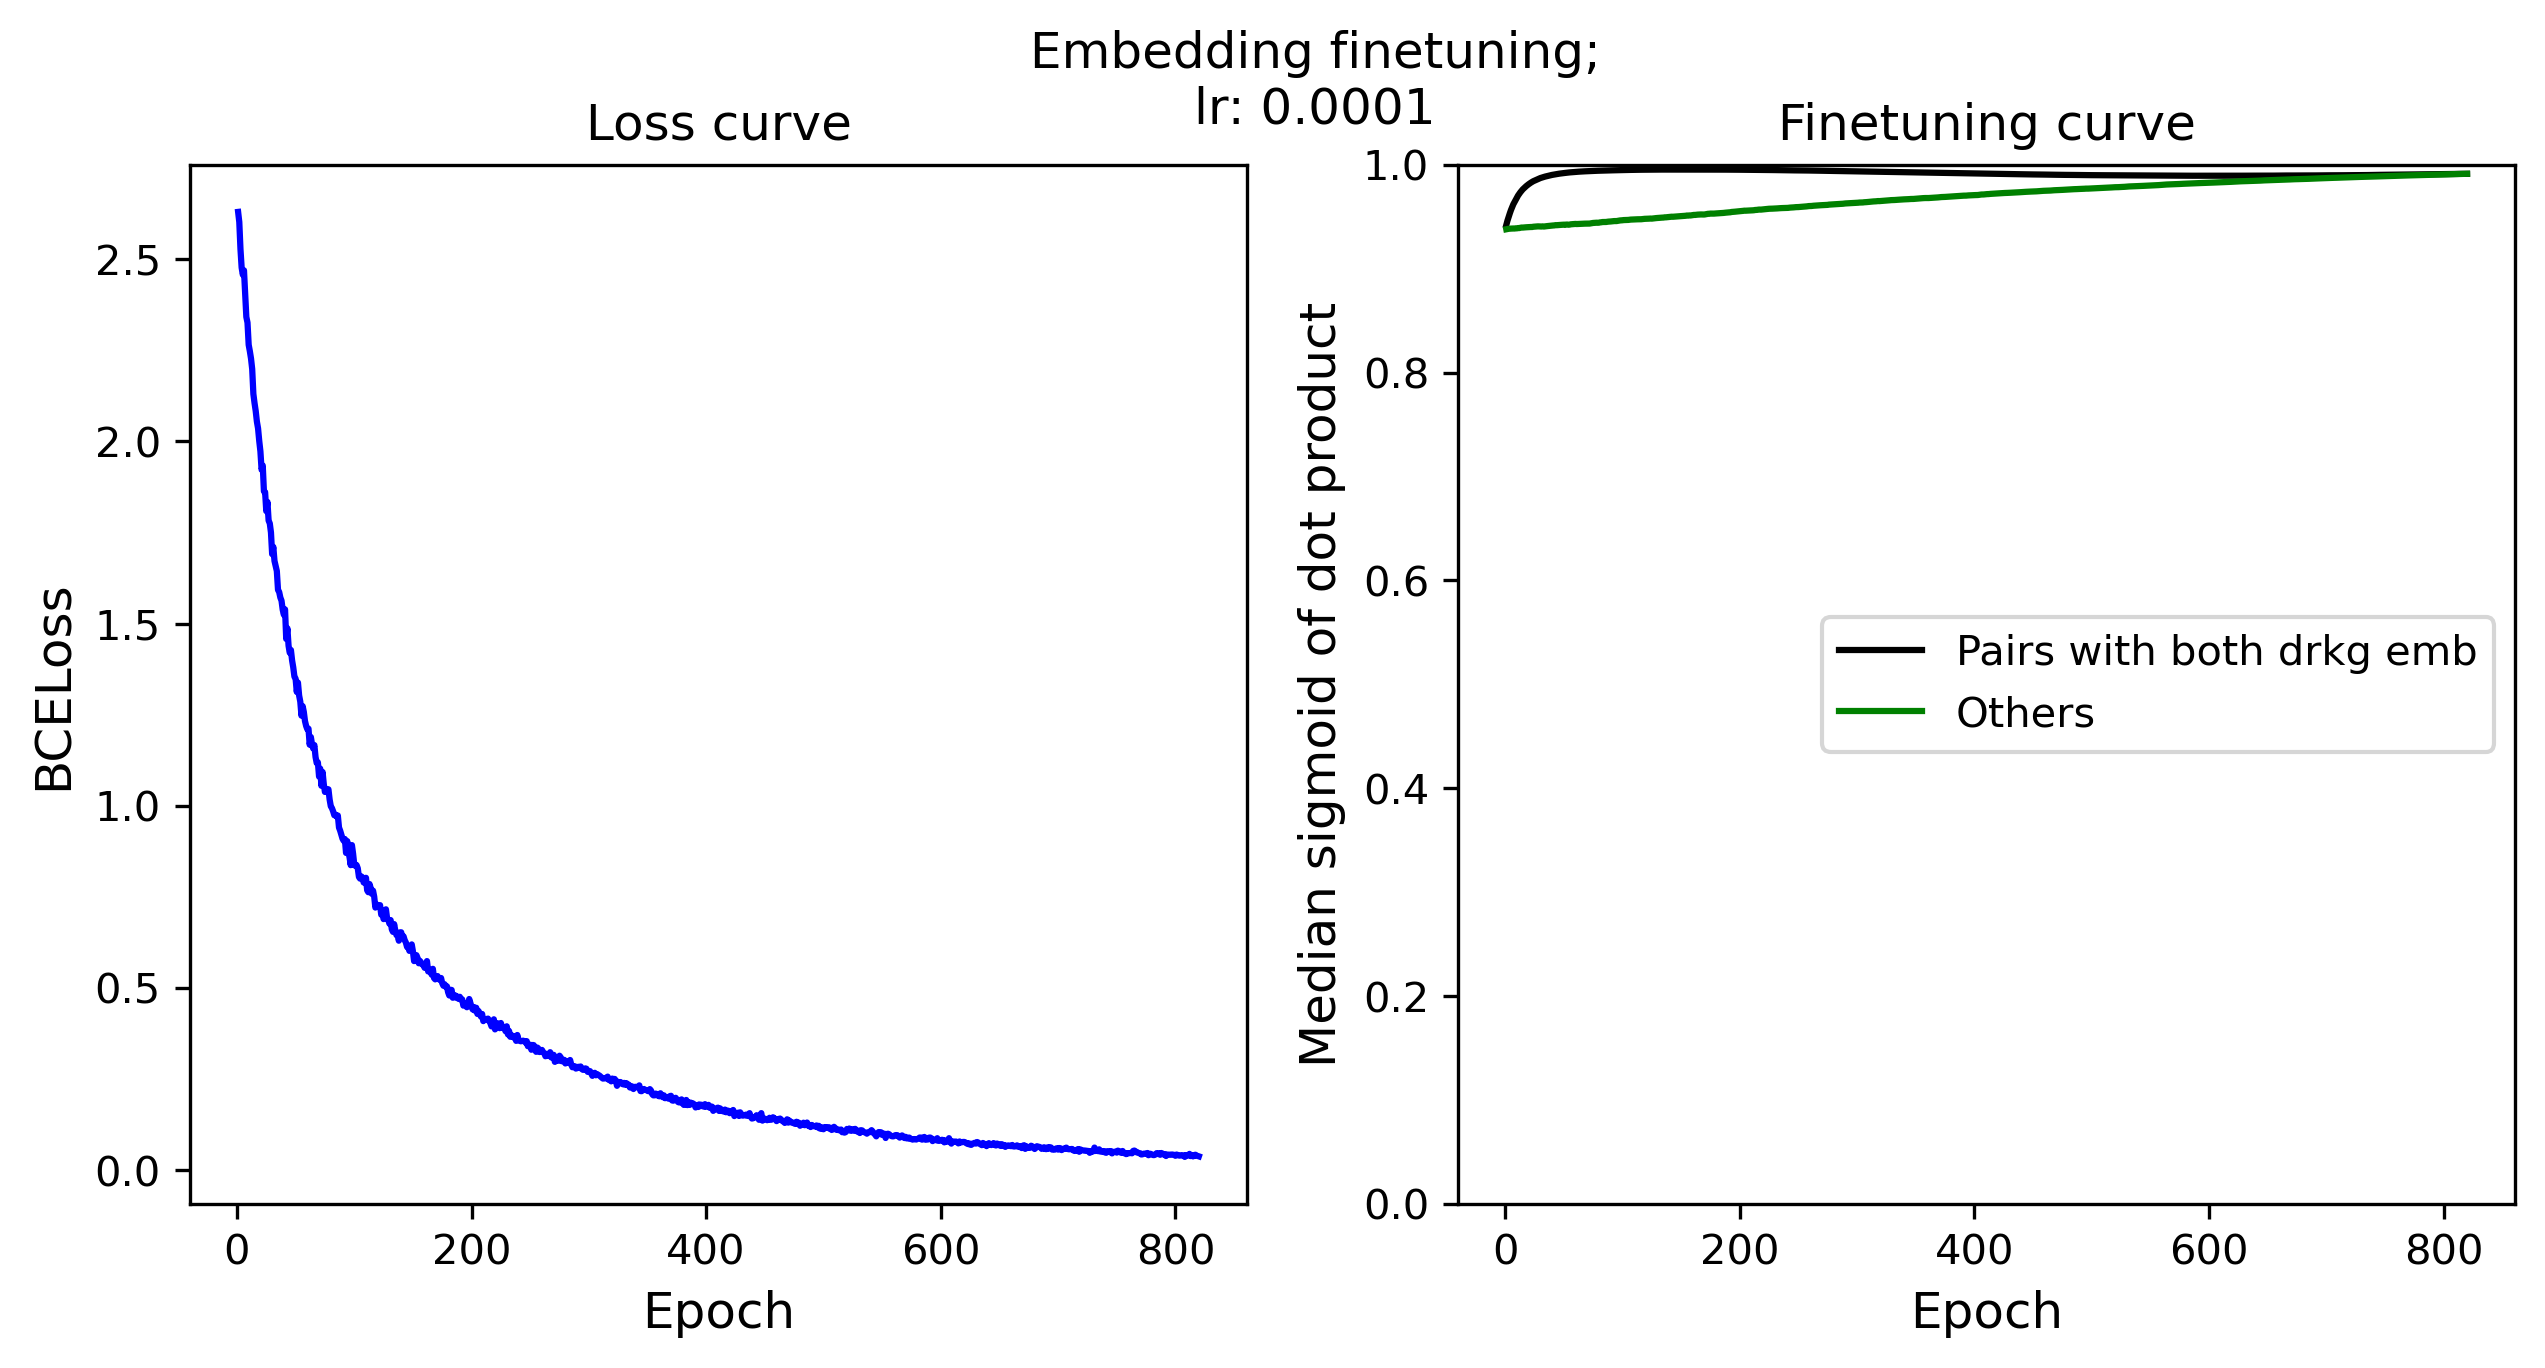

In [30]:
# When training partition is 1
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), dpi=300)
fig.suptitle(f"Embedding finetuning;\n" + 
             f"lr: {lr}", fontsize=12)

axes[0].plot(range(1,1+len(train_loss_list)), train_loss_list, color='blue')
axes[0].set_title('Loss curve', fontsize=12)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('BCELoss', fontsize=12)
# axes[0].legend(loc='upper right')

axes[1].plot(range(1,1+len(medium_drkg_list)), medium_drkg_list, color='black', label="Pairs with both drkg emb")
axes[1].plot(range(1,1+len(medium_trained_list)), medium_trained_list, color='green', label="Others")
axes[1].set_title('Finetuning curve', fontsize=12)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Median sigmoid of dot product', fontsize=12)
axes[1].set_ylim(0, 1)
axes[1].legend(loc='right')

# Show the plot
# plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to accommodate general title
plt.show()


### Load the fine-tuned embedding and do the plot

In [8]:
model = Embedding_finetuning(input_emb_size, N_node)
# 1 means we use all the samples to train
train_partition = 1

# Path to your saved file
embedding_load_path = work_dir+f'finetuned_emb_{train_partition}.npy'
loaded_weights = np.load(embedding_load_path)
loaded_weights_tensor = torch.tensor(loaded_weights, dtype=torch.float32)
model.emb.weight.data = loaded_weights_tensor

In [9]:
# Extract embeddings
emb_layer = np.array(model.emb.weight.data)
# Index extraction for conditions and drugs
cond_indices = drug_cond_df['cond_idx'].values
drug_indices = drug_cond_df['drug_idx'].values
# Retrieve the corresponding embeddings
cond_embs = emb_layer[cond_indices]
drug_embs = emb_layer[drug_indices]
# Compute dot product and apply sigmoid
dot_products = sigmoid(np.einsum('ij,ij->i', cond_embs, drug_embs))
# Split dot products based on condition
n_emb = len(embedding_cond1) + len(embedding_drug1)
is_drkg_pair = (cond_indices < n_emb) & (drug_indices < n_emb)
# Compute medians
dot_product_list_drkg = dot_products[is_drkg_pair]
dot_product_list_trained = dot_products[~is_drkg_pair]

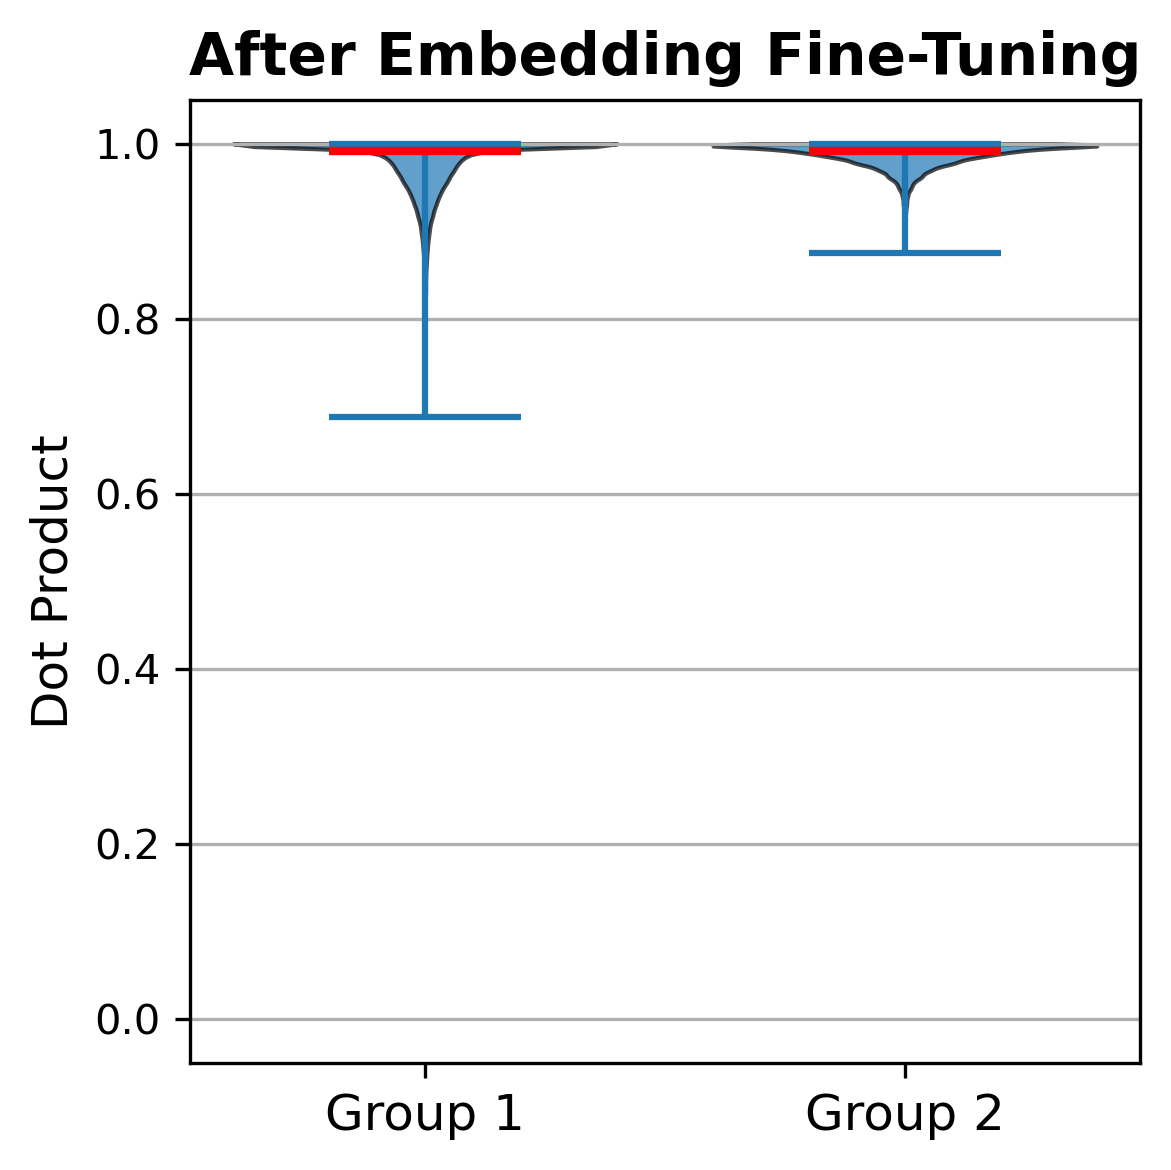

In [10]:
# plot
data = [dot_product_list_drkg, dot_product_list_trained]
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

# violin plot with polished appearance
parts = ax.violinplot(data, showmedians=True, widths=0.8)

# make violins cleaner and slightly transparent
for pc in parts['bodies']:
    pc.set_facecolor('#1f77b4')
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# median line styling
if 'cmedians' in parts:
    parts['cmedians'].set_color('red')
    parts['cmedians'].set_linewidth(2)

# axes and labels
ax.set_xticks([1, 2])
ax.set_xticklabels(['Group 1', 'Group 2'], fontsize=12)
ax.tick_params(axis='y', labelsize=10)
ax.set_ylabel('Dot Product', fontsize=12)
ax.set_title('After Embedding Fine-Tuning', fontsize=14, weight='bold')

# set ylim from 0 to 1
ax.set_ylim(-0.05, 1.05)

# grid for readability
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()